# SQL Server Connection Setup

In [266]:
# --- SQL Server Connection Test ---
import pyodbc
import pandas as pd

# STEP 1: Check available ODBC drivers
print("Available ODBC Drivers:")
for driver in pyodbc.drivers():
  print("   ", driver)

# STEP 2: Define connection details
server = "localhost\\SQL2022"              # Change if your instance name differs
database = "QuickStart_DataScience"        # Change to your database
driver = "SQL Server"                      # Use one listed above
#driver = "ODBC Driver 18 for SQL Server"  # Use one listed above
trusted_connection = "yes"                 # or "no" if using SQL auth
encrypt = "no"                             # disable encryption for local

conn_str = ( f"DRIVER={{{driver}}};"
             f"SERVER={server};"
             f"DATABASE={database};"
             f"Trusted_Connection={trusted_connection};"
             f"Encrypt={encrypt};" )

print("\nConnecting with:")
print(conn_str)

# STEP 3: Test connection and query
try:
  with pyodbc.connect(conn_str) as conn:
    query = "SELECT TOP 10 name, database_id FROM sys.databases ORDER BY name DESC;"
    df = pd.read_sql(query, conn)
    print("\nConnection successful! Sample query output:")
    display(df)
except Exception as e:
  print("\nConnection failed!")
  print(str(e))


Available ODBC Drivers:
    SQL Server
    ODBC Driver 17 for SQL Server
    ODBC Driver 18 for SQL Server
    Microsoft Access Driver (*.mdb, *.accdb)
    Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)
    Microsoft Access Text Driver (*.txt, *.csv)
    Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)

Connecting with:
DRIVER={SQL Server};SERVER=localhost\SQL2022;DATABASE=QuickStart_DataScience;Trusted_Connection=yes;Encrypt=no;

Connection successful! Sample query output:


C:\Users\randel.bjorkquist\AppData\Local\Temp\ipykernel_16436\4000086518.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,name,database_id
0,VideoGameCharacters,14
1,tempdb,2
2,ReportServerTempDB,9
3,ReportServer,8
4,QuickStart_DataScience,15
5,NZWalksAuth,13
6,NZWalks,12
7,msdb,4
8,model,3
9,master,1


<details>
<summary><strong>Database Connection Setup</strong></summary>

This code establishes a **connection between Python (via SQLAlchemy)** and a **local Microsoft SQL Server 2022 instance** named `SQL2022`, using **Windows Authentication** (trusted connection).  
- `create_engine(...)` defines a connection string to the **database** (`QuickStart_DataScience`) via the **ODBC Driver 18 for SQL Server**, using the **connection protocol** (`mssql+pyodbc`), **server** (`localhost\SQL2022`).
- The parameters `driver=ODBC Driver 18 for SQL Server`, `trusted_connection=yes`, and `Encrypt=no` configure how the connection is authenticated and secured.  
- Once created, the `engine` object can be passed to pandas functions such as `pd.read_sql()` to **execute SQL queries directly from Python** and **load results into a DataFrame** for analysis or visualization.

</details>

In [267]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine("mssql+pyodbc://localhost\\SQL2022/QuickStart_DataScience?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes&Encrypt=no")


In [268]:
# NOTE: 'engine' defined above ...

select_all_from_allstarfull   = "SELECT * FROM dbo.AllstarFull"
select_top10_from_allstarfull = "SELECT TOP 10 * FROM dbo.AllstarFull"

df = pd.read_sql(select_top10_from_allstarfull, engine)
df.head()


,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,kalinal01,1957,0,NLS195707090,DET,AL,1,9
1,demaejo01,1957,0,NLS195707090,KC1,AL,0,None
2,grimbo01,1957,0,NLS195707090,NYA,AL,1,None
3,howarel01,1957,0,NLS195707090,NYA,AL,0,None
4,loesbi01,1957,0,NLS195707090,BAL,AL,1,None


# Project 3: Data Querying and Cleaning (SQL-Centric Version)

<details>
<summary><strong>Overview</strong></summary>

This version of **Project 3** emphasizes using **SQL** for data cleaning, transformation, and aggregation, while Python handles visualization and analysis.  
By leveraging SQL’s efficiency and relational structure, you ensure that Python receives clean, structured, and aggregated data that’s ready for analytics.

I’ve enhanced the database with a `deleted` bit column in each major table (`People`, `Appearances`, and `Batting`) to *soft delete* invalid or incomplete rows.  
This keeps the data historically intact while maintaining analytical integrity.

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 1: Data Cleaning with SQL</strong></summary>

### 1.1 Backup Original Tables
```sql
SELECT * INTO People_backup       FROM dbo.People;
SELECT * INTO Appearances_backup  FROM dbo.Appearances;
SELECT * INTO Batting_backup      FROM dbo.Batting;
```

### 1.2 Add `deleted` Column
```sql
ALTER TABLE dbo.People      ADD deleted BIT NOT NULL DEFAULT 0;
ALTER TABLE dbo.Appearances ADD deleted BIT NOT NULL DEFAULT 0;
ALTER TABLE dbo.Batting     ADD deleted BIT NOT NULL DEFAULT 0;
```

### 1.3 Flag Invalid Records
Soft-delete rows with missing or invalid key fields (e.g., missing name, birth date, stats):

```sql
UPDATE P
SET deleted = 1
FROM dbo.People P
WHERE P.deleted = 0
  AND (P.playerID IS NULL OR
       P.birthYear IS NULL OR
       P.nameFirst IS NULL OR
       P.nameLast IS NULL OR
       P.weight IS NULL);
```
Apply similar rules to `Batting` and `Appearances`. Records remain in the database but are **excluded from analytics** using `WHERE deleted = 0`.

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 2: Data Extraction and Transformation with SQL</strong></summary>

### 2.1. Common Table Expressions (CTEs)

The query defines three key CTEs:

#### `active_players_2018`

Filters for **active players** whose `finalGame` is after 2017-12-31 (or
null, defaulting to current date). Ensures the player is not deleted and
enriches player data with calculated fields.

``` sql
active_players_2018 AS (
  SELECT 
     PL.*
    ,TRIM(AP.nameFirst) + ' ' + TRIM(AP.nameLast) AS 'playerName'
    ,DATEDIFF(YEAR, DATEFROMPARTS(AP.birthYear, AP.birthMonth, AP.birthDay), GETDATE())
      - CASE 
          WHEN MONTH(GETDATE()) < AP.birthMonth OR
              MONTH(GETDATE()) = AP.birthMonth AND 
                DAY(GETDATE()) < AP.birthDay 
          THEN 1 ELSE 0 
        END AS 'playerAge'
  FROM 
    dbo.People AS PL
  WHERE 
    PL.deleted = 0
    AND ISNULL(PL.finalGame, GETDATE()) > '2017/12/31'
)
```

#### `eligibile_players`

Identifies players who have appeared in **at least 50 games** by summing
their `G_all` appearances across all teams and seasons. Deleted
appearances are excluded.

``` sql
eligibile_players AS (
  SELECT 
    AP.playerID
  FROM 
    dbo.Appearances AS AP
  WHERE 
    AP.deleted = 0
  GROUP BY 
    AP.playerID
  HAVING 
    SUM(CAST(AP.G_all AS INT)) >= 50
)
```

#### `batting_stats`

Aggregates each player's **batting stats per year**, combining multiple
`stint` entries (e.g., from mid-season trades) into a single record per
year.\

``` sql
batting_stats AS (
  SELECT
     B.playerID,
     B.yearID,
     SUM(CAST(G       AS INT))  AS       'G',
     SUM(CAST(AB      AS INT))  AS      'AB',
     SUM(CAST(R       AS INT))  AS       'R',
     SUM(CAST(H       AS INT))  AS       'H',
     SUM(CAST(_2B     AS INT))  AS     '_2B',
     SUM(CAST(_3B     AS INT))  AS     '_3B',
     SUM(CAST(HR      AS INT))  AS      'HR',
     SUM(CAST(RBI     AS INT))  AS     'RBI',
     SUM(CAST(SB      AS INT))  AS      'SB',
     SUM(CAST(CS      AS INT))  AS      'CS',
     SUM(CAST(BB      AS INT))  AS      'BB',
     SUM(CAST(SO      AS INT))  AS      'SO',
     SUM(CAST(IBB     AS INT))  AS     'IBB',
     SUM(CAST(HBP     AS INT))  AS     'HBP',
     SUM(CAST(SH      AS INT))  AS      'SH',
     SUM(CAST(SF      AS INT))  AS      'SF',
     SUM(CAST(GIDP    AS INT))  AS    'GIDP'
  FROM 
    dbo.Batting AS B
  WHERE 
    B.deleted = 0
  GROUP BY 
     B.playerID
    ,B.yearID
)
```

**What this does**
- Includes only non-deleted, active players (post‑2017)
- Requires ≥ 50 games played (eligibility)
- Aggregates all batting stats to 1 row per player‑year (handles trades ' stints')
- Returns player metadata, calculated age, and stats

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 3: Analytical Queries & Visualizations</strong></summary>

### 1A. Player with Most RBI (2015–2018)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT TOP 10
   AP.playerID
  ,TRIM(AP.nameFirst) + ' ' + TRIM(AP.nameLast) AS playerName
  ,SUM(B.RBI) AS totalRBI
FROM
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  BS.yearID BETWEEN 2015 AND 2018
GROUP BY
   AP.playerID
  ,AP.playerName
ORDER BY 
  totalRBI DESC;
```

### 1B. Albert Pujols — GIDP in 2016
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT 
   AP.playerName
  ,BS.yearID
  ,BS.GIDP
FROM
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
WHERE 
  BS.yearID = 2016
  AND AP.playerName = 'Pujols Albert'
GROUP BY
  B.yearID;
```

### 2A. Histogram of Triples per Year (SQL summary for Python)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
    B.yearID,
    SUM(B.[3B]) AS totalTriples
FROM 
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID;
```

### 2B. Scatter Plot — Triples vs Steals (player‑year)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
   AP.playerID
  ,AP.playerName
  ,B.yearID
  ,B._3B AS '3B'
  ,B.SB
FROM active_players_2018    AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
ORDER BY
  B.yearID;
```

*Python examples for plotting:*
```python
# Histogram of Triples per Year (from the yearly summary df)
df.plot(kind='bar', x='yearID', y='totalTriples', title='Triples per Year')

# Scatter: Triples vs Steals (from player-year df)
plt.scatter(df['3B'], df['SB'])
plt.xlabel('Triples')
plt.ylabel('Stolen Bases')
plt.title('Relationship between Triples and Steals')
```

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 4: Additional Analytical Questions</strong></summary>

### (1) Highest Batting Average in 2018
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT TOP 10
   AP.playerName
  ,CAST(B.H AS FLOAT) / NULLIF(B.AB, 0) AS 'BA'
FROM 
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE 
  BS.yearID = 2018
ORDER BY
  BA DESC;
```

### (2) Walks vs Strikeouts by Year (for correlation)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
   B.yearID
  ,SUM(B.BB)
  ,SUM(B.SO)
FROM 
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID;
```
*Python:* `plt.scatter(df['totalWalks'], df['totalStrikeouts'])`

### (3) Largest HR Increase from 2017 → 2018
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
   AP.playerID
  ,AP.playerName
  ,SUM(CASE WHEN yearID = 2018 THEN BS.HR ELSE 0 END) - 
   SUM(CASE WHEN yearID = 2017 THEN BS.HR ELSE 0 END) AS 'HR_Improvement'
FROM
  active_players                AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats  AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
   AP.playerID
  ,AP.playerName
ORDER BY
  HR_Improvement DESC;
```

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Summary</strong></summary>

**SQL handles**
- Data validation with `deleted` soft‑deletes  
- Eligibility & active‑player filters  
- Per‑player, per‑year aggregation (trade‑safe)  
- Computed fields (age, concatenated name)

**Python handles**
- Plotting and EDA (histograms, scatter, correlation)  
- Answer formatting and presentation in the notebook

This SQL‑first workflow keeps Python focused on insights, not data wrangling.

</details>


### Full SQL command with CTEs and final SELECT, 'valid' data only


In [280]:
# 'engine' defined above ...
full_sql_command = """
;WITH active_players AS (
  SELECT
     P.*
    ,TRIM(P.nameFirst) + ' ' + TRIM(P.nameLast) AS playerName
    ,DATEDIFF(YEAR, DATEFROMPARTS(P.birthYear, P.birthMonth, P.birthDay), GETDATE())
      - CASE 
          WHEN MONTH(GETDATE()) < P.birthMonth OR
              MONTH(GETDATE())  = P.birthMonth AND 
                DAY(GETDATE())  < P.birthDay 
          THEN 1 ELSE 0 
        END AS 'playerAge'    
  FROM
    dbo.People AS P
  WHERE
    P.deleted = 0 AND 
    ISNULL(P.finalGame, GETDATE()) > '2017/12/31'
),
eligible_players AS (
  SELECT
    A.playerID
  FROM
    dbo.Appearances AS A
  WHERE
    A.deleted = 0
  GROUP BY
    A.playerID
  HAVING
    SUM(CAST(A.G_all AS INT)) >= 50
),
batting_stats AS (
  SELECT
     B.playerID
    ,B.yearID
    ,SUM(CAST(G       AS INT))  AS    'G'
    ,SUM(CAST(AB      AS INT))  AS   'AB'
    ,SUM(CAST(R       AS INT))  AS    'R'
    ,SUM(CAST(H       AS INT))  AS    'H'
    ,SUM(CAST(_2B     AS INT))  AS  '_2B'
    ,SUM(CAST(_3B     AS INT))  AS  '_3B'
    ,SUM(CAST(HR      AS INT))  AS   'HR'
    ,SUM(CAST(RBI     AS INT))  AS  'RBI'
    ,SUM(CAST(SB      AS INT))  AS   'SB'
    ,SUM(CAST(CS      AS INT))  AS   'CS'
    ,SUM(CAST(BB      AS INT))  AS   'BB'
    ,SUM(CAST(SO      AS INT))  AS   'SO'
    ,SUM(CAST(IBB     AS INT))  AS  'IBB'
    ,SUM(CAST(HBP     AS INT))  AS  'HBP'
    ,SUM(CAST(SH      AS INT))  AS   'SH'
    ,SUM(CAST(SF      AS INT))  AS   'SF'
    ,SUM(CAST(GIDP    AS INT))  AS 'GIDP'
  FROM
    Batting AS B
  WHERE    
    B.deleted = 0
  GROUP BY
     B.playerID
    ,B.yearID
  HAVING
    SUM(CAST(B.G AS INT)) >= 50
)
SELECT
   AP.playerID
  ,AP.playerName
  ,AP.[weight]
  ,AP.throws
  ,AP.playerAge
  ,AP.birthCountry
  ,AP.birthState
  ,AP.birthCity
  ,BS.yearID
  ,BS.G
  ,BS.AB
  ,BS.R
  ,BS.H
  ,BS._2B AS '2B'
  ,BS._3B AS '3B'
  ,BS.HR
  ,BS.RBI
  ,BS.SB
  ,BS.CS
  ,BS.BB
  ,BS.SO
  ,BS.IBB
  ,BS.HBP
  ,BS.SH
  ,BS.SF
  ,BS.GIDP
FROM active_players AS AP
  INNER JOIN eligible_players AS EP
    INNER JOIN batting_stats AS BS
      ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
ORDER BY 
   AP.playerID  ASC
  ,BS.yearID    DESC;
"""

df = pd.read_sql(full_sql_command, engine)
df.head(25)


,playerID,playerName,weight,throws,playerAge,birthCountry,birthState,birthCity,yearID,G,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2016,57,...,0,0,0,0,1,0,0,0,0,0
1,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2015,62,...,0,0,0,0,0,0,0,0,0,0
2,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2014,69,...,0,0,0,0,0,0,0,0,0,0
3,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2023,151,...,64,47,4,32,118,2,13,3,3,7
4,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2022,90,...,21,7,4,5,50,0,9,2,2,5
5,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2023,72,...,0,0,0,0,0,0,0,0,0,0
6,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2022,55,...,0,0,0,0,0,0,0,0,0,0
7,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2023,141,...,90,0,1,42,130,1,6,0,6,16
8,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2022,157,...,75,0,0,62,110,2,12,0,4,19
9,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2021,152,...,117,1,0,61,143,3,22,0,10,28


### Common Table Expressions (CTEs)
This illustrates how to separate CTEs for reuse. In different code cells below, SELECT statements \
are defined, using these same CTEs, without having to redefine them, and allowing the developer to \
focus specifially on what they want to accomplish and not how to pull or define the base data.

In [281]:
# IMPORTANT: this code cell, defines and separates the CTEs from the 'full_sql_command' above.
CTEs = """
;WITH active_players AS (
  SELECT
     P.*
    ,TRIM(P.nameFirst) + ' ' + TRIM(P.nameLast) AS playerName
    ,DATEDIFF(YEAR, DATEFROMPARTS(P.birthYear, P.birthMonth, P.birthDay), GETDATE())
      - CASE 
        WHEN MONTH(GETDATE()) < P.birthMonth OR
             MONTH(GETDATE()) = P.birthMonth AND 
               DAY(GETDATE()) < P.birthDay 
        THEN 1 ELSE 0 
      END AS 'playerAge'
  FROM
    dbo.People AS P
  WHERE
    P.deleted = 0 AND 
    ISNULL(P.finalGame, GETDATE()) > '2017/12/31'
),
eligible_players AS (
  SELECT
    A.playerID
  FROM
    dbo.Appearances AS A
  WHERE
    A.deleted = 0
  GROUP BY
    A.playerID
  HAVING
    SUM(CAST(A.G_all AS INT)) >= 50
),
batting_stats AS (
  SELECT
     B.playerID
    ,B.yearID
    ,SUM(CAST(G       AS INT))  AS    'G'
    ,SUM(CAST(AB      AS INT))  AS   'AB'
    ,SUM(CAST(R       AS INT))  AS    'R'
    ,SUM(CAST(H       AS INT))  AS    'H'
    ,SUM(CAST(_2B     AS INT))  AS  '_2B'
    ,SUM(CAST(_3B     AS INT))  AS  '_3B'
    ,SUM(CAST(HR      AS INT))  AS   'HR'
    ,SUM(CAST(RBI     AS INT))  AS  'RBI'
    ,SUM(CAST(SB      AS INT))  AS   'SB'
    ,SUM(CAST(CS      AS INT))  AS   'CS'
    ,SUM(CAST(BB      AS INT))  AS   'BB'
    ,SUM(CAST(SO      AS INT))  AS   'SO'
    ,SUM(CAST(IBB     AS INT))  AS  'IBB'
    ,SUM(CAST(HBP     AS INT))  AS  'HBP'
    ,SUM(CAST(SH      AS INT))  AS   'SH'
    ,SUM(CAST(SF      AS INT))  AS   'SF'
    ,SUM(CAST(GIDP    AS INT))  AS 'GIDP'
  FROM
    Batting AS B
  WHERE    
    B.deleted = 0
  GROUP BY
     B.playerID
    ,B.yearID
  HAVING
    SUM(CAST(B.G AS INT)) >= 50
)
"""

In [282]:
#'engine' AND 'CTEs' are defined above, this code cell focuses on a simple SELECT statement example.
select = """
SELECT
   AP.playerID
  ,AP.playerName
  ,AP.[weight]
  ,AP.throws
  ,AP.playerAge
  ,AP.birthCountry
  ,AP.birthState
  ,AP.birthCity
  ,BS.yearID
  ,BS.G
  ,BS.AB
  ,BS.R
  ,BS.H
  ,BS._2B AS '2B'
  ,BS._3B AS '3B'
  ,BS.HR
  ,BS.RBI
  ,BS.SB
  ,BS.CS
  ,BS.BB
  ,BS.SO
  ,BS.IBB
  ,BS.HBP
  ,BS.SH
  ,BS.SF
  ,BS.GIDP
FROM active_players AS AP
  INNER JOIN eligible_players AS EP
    INNER JOIN batting_stats AS BS
      ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
ORDER BY 
   AP.playerID  ASC
  ,BS.yearID    DESC;
"""

command = CTEs + select

df = pd.read_sql(command, engine)
df.head(25)

,playerID,playerName,weight,throws,playerAge,birthCountry,birthState,birthCity,yearID,G,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2016,57,...,0,0,0,0,1,0,0,0,0,0
1,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2015,62,...,0,0,0,0,0,0,0,0,0,0
2,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2014,69,...,0,0,0,0,0,0,0,0,0,0
3,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2023,151,...,64,47,4,32,118,2,13,3,3,7
4,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2022,90,...,21,7,4,5,50,0,9,2,2,5
5,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2023,72,...,0,0,0,0,0,0,0,0,0,0
6,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2022,55,...,0,0,0,0,0,0,0,0,0,0
7,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2023,141,...,90,0,1,42,130,1,6,0,6,16
8,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2022,157,...,75,0,0,62,110,2,12,0,4,19
9,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2021,152,...,117,1,0,61,143,3,22,0,10,28


### Retrieves the Players having the TOP 10 RBIs for 2015 through 2018.

In [283]:
#'engine' AND 'CTEs' are defined above ...
rbis_for_2015_through_2018 = """
SELECT TOP 10
   AP.playerName                AS 'Player Name'
  ,SUM(CAST(BS.RBI AS INT))     AS 'Total RBIs'
FROM active_players             AS AP
  INNER JOIN eligible_players   AS EP
    INNER JOIN batting_stats    AS BS
      ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
WHERE
  BS.yearID BETWEEN 2015 AND 2018
GROUP BY
   AP.PlayerName
  ,AP.playerID
ORDER BY
    [Total RBIs] DESC
"""

RBIs = CTEs + rbis_for_2015_through_2018

df = pd.read_sql(RBIs, engine)
df.head(10)

,Player Name,Total RBIs
0,Nolan Arenado,503
1,Edwin Encarnacion,452
2,Anthony Rizzo,420
3,Nelson Cruz,414
4,Paul Goldschmidt,408
5,J. D. Martinez,404
6,Khris Davis,401
7,Manny Machado,384
8,Jose Abreu,381
9,Albert Pujols,379


### Retrieves Albert Pujols' GIDP (Grounded Into Double Plays) stat for 2016

In [284]:
#'engine' AND 'CTEs' are defined above ...
albert_pujols_2016_gidp = """
SELECT
   AP.playerName              AS 'Player Name'
  ,BS.yearID                  AS 'Year' 
  ,BS.GIDP                    AS 'GIDPs'
FROM
  active_players                AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats  AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  AP.playerName = 'Albert Pujols'
  AND BS.yearID = 2016
"""

GIDPs = CTEs + albert_pujols_2016_gidp

df = pd.read_sql(GIDPs, engine)
df.head(10)

,Player Name,Year,GIDPs
0,Albert Pujols,2016,24


### Retrieves the total number of triples per year

<Axes: title={'center': 'Total Triples per Year (Active Players with ≥50 Games)'}, xlabel='Year', ylabel='Total Triples'>

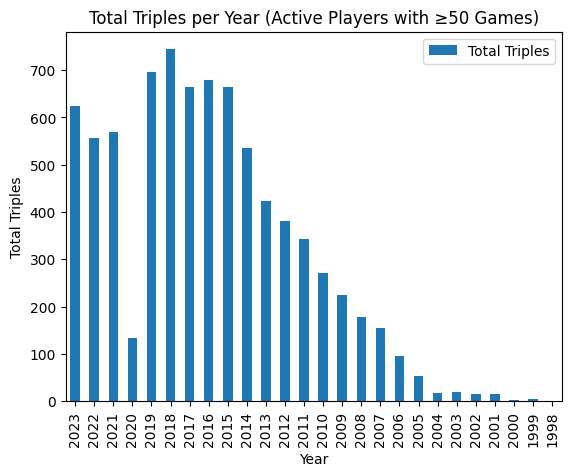

In [285]:
#'engine' AND 'CTEs' are defined above ...
triples_per_year = """
SELECT
   BS.yearID      AS 'Year'
  ,SUM(BS._3B)    AS 'Total Triples'
FROM
  active_players                  AS AP
    INNER JOIN eligible_players   AS EP 
      INNER JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID DESC;
"""

triples = CTEs + triples_per_year

df = pd.read_sql(triples, engine)
df.plot.bar( x = 'Year'
            ,y = 'Total Triples'
            ,title  = 'Total Triples per Year (Active Players with ≥50 Games)'
            ,xlabel = 'Year'
            ,ylabel = 'Total Triples')


### Retrieves and plots triples vs stolen bases for active players

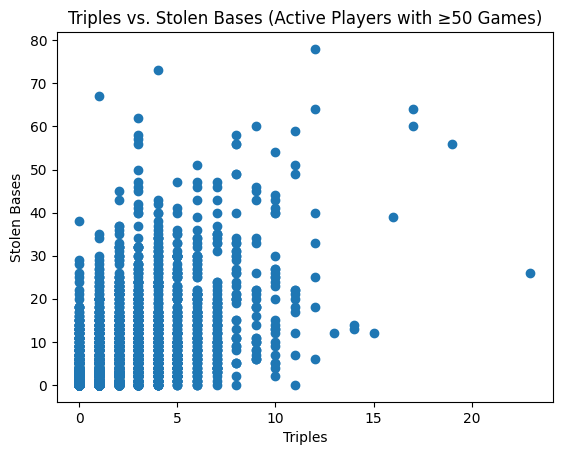

In [286]:
#'engine' AND 'CTEs' are defined above ...
triples_vs_steals = """
SELECT
   AP.playerName    AS 'Player Name'
  ,BS.yearID        AS 'Year'
  ,BS._3B           AS 'Triples'
  ,BS.SB            AS 'Stolen Bases'
FROM
  active_players                  AS AP
    INNER JOIN eligible_players   AS EP 
      INNER JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
ORDER BY
  BS.yearID ASC;
"""

triplesVSsteals = CTEs + triples_vs_steals

df = pd.read_sql(triplesVSsteals, engine)

#NOTE: matplotlib imported for plotting and visualization
from matplotlib import pyplot as plt

plt.scatter( df['Triples'], df['Stolen Bases'] )
plt.title('Triples vs. Stolen Bases (Active Players with ≥50 Games)')
plt.xlabel('Triples')
plt.ylabel('Stolen Bases')

plt.show()


### Retrieves the TOP 10 Batting Averages for 2018

In [287]:
#'engine' AND 'CTEs' are defined above ...
top10_2018_batting_averages = """
SELECT TOP 10
  AP.playerName                                         AS 'Player Name'
 ,CAST(BS.H AS FLOAT) / NULLIF(CAST(BS.AB AS FLOAT), 0) AS 'BA'
 ,BS.AB                                                 AS 'AB'
FROM
  active_players AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  BS.yearID = 2018
  AND BS.AB >= 100
ORDER BY
   BA    DESC
  ,BS.AB DESC;
"""

battingAverages = CTEs + top10_2018_batting_averages

df = pd.read_sql(battingAverages, engine)
df.head(10)


,Player Name,BA,AB
0,Mookie Betts,0.346154,520
1,J. D. Martinez,0.330404,569
2,Jeff McNeil,0.328889,225
3,Christian Yelich,0.325784,574
4,Jose Altuve,0.316479,534
5,Justin Turner,0.312329,365
6,Mike Trout,0.312102,471
7,Scooter Gennett,0.309932,584
8,Freddie Freeman,0.309061,618
9,Michael Brantley,0.308772,570


### Retrieves and plots the total walks vs strikeouts per year

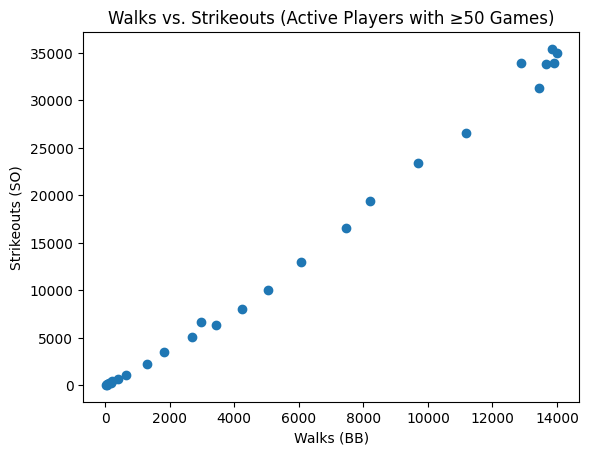

In [288]:
#'engine' AND 'CTEs' are defined above ...
bbVSso = """
SELECT
   BS.yearID  AS 'Year'
  ,SUM(BS.BB) AS 'Total BB'
  ,SUM(BS.SO) AS 'Total SO'
FROM
  active_players                  AS AP
    INNER JOIN eligible_players   AS EP 
      INNER JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID DESC;
"""

walksVSstrikeouts = CTEs + bbVSso
df = pd.read_sql(walksVSstrikeouts, engine)

plt.scatter( df['Total BB'], df['Total SO'] )
plt.title('Walks vs. Strikeouts (Active Players with ≥50 Games)')
plt.xlabel('Walks (BB)') 
plt.ylabel('Strikeouts (SO)')
plt.show()

### Calculates the TOP 10 most improved players from 2017 to 2018
- HR (Home Runs) are the measure

In [289]:
#'engine' AND 'CTEs' are defined above ...
most_improved_players = """
SELECT TOP 10
   AP.playerName                                      AS 'Player Name'
  ,SUM(CASE WHEN yearID = 2023 THEN BS.HR ELSE 0 END) AS 'HRs in 2023'
  ,SUM(CASE WHEN yearID = 2022 THEN BS.HR ELSE 0 END) AS 'HRs in 2022'
  ,SUM(CASE WHEN yearID = 2023 THEN BS.HR ELSE 0 END) - 
   SUM(CASE WHEN yearID = 2022 THEN BS.HR ELSE 0 END) AS 'Improvement'
FROM
  active_players                AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats  AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  BS.yearID IN (2022, 2023)
  AND BS.AB >= 100
GROUP BY
   AP.playerName
HAVING  
  SUM(CASE WHEN yearID = 2022 THEN BS.HR ELSE 0 END) > 0
ORDER BY
  Improvement DESC;
"""

most_improved = CTEs + most_improved_players

df = pd.read_sql(most_improved, engine)
df


,Player Name,HRs in 2023,HRs in 2022,Improvement
0,Jake Burger,34,8,26
1,Ronald Acuna,41,15,26
2,Jorge Soler,36,13,23
3,Spencer Torkelson,31,8,23
4,Matt Olson,54,34,20
5,Jose Siri,25,7,18
6,Josh Lowe,20,2,18
7,J. D. Martinez,33,16,17
8,Marcell Ozuna,40,23,17
9,CJ Abrams,18,2,16


# Project 3: Data Querying and Cleaning (Python-Centric Version)

In [279]:
#NOTE: I am building the 'playerName' within the above SQL.  
# Another way to do it is below:
#df['player_name'] = df['nameFirst'].str.strip() + ' ' + df['nameLast'].str.strip()

#NOTE: I'm also building the 'playerAge' within the above SQL.  
# Another way to do it is below:
#from datetime import datetime
#def calculate_age(row):
#  birth_year  = row['birthYear']
#  birth_month = row['birthMonth']
#  birth_day   = row['birthDay']
#
#  if pd.isnull(birth_year) or pd.isnull(birth_month) or pd.isnull(birth_day):
#    return pd.NA
#
#  today = datetime.today()
#  age   = today.year - int(birth_year)
#
#  if (today.month, today.day) < (int(birth_month), int(birth_day)):
#    age -= 1
#    
#  return age

#df['player_age'] = df.apply(calculate_age, axis = 1)
#df

#columns_to_drop = [ 'nameFirst', 'nameLast', 'nameGiven',
#                    'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity']
#df = df.drop(columns = columns_to_drop)

# Delete any rows with missing values
#df = df.dropna()

#df.head(25)